这是一个自行车租赁系统，数据提供了为2年内华盛顿按小时记录的自行车租赁数据，其中训练集由每个月的前19天组成，测试集由20号之后的时间组成（需要我们自己去预测）

# 数据处理与预处理

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [2]:
df_train = pd.read_csv('../../Kaggle_data/bicycle/kaggle_bike_competition_train.csv',header=0)

In [3]:
df_train.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


In [4]:
# 每个字段的名字
df_train.dtypes

datetime       object
season          int64
holiday         int64
workingday      int64
weather         int64
temp          float64
atemp         float64
humidity        int64
windspeed     float64
casual          int64
registered      int64
count           int64
dtype: object

In [5]:
# 数据的大小
df_train.shape

(10886, 12)

In [6]:
# 检查数据是否有缺省值
df_train.count()

datetime      10886
season        10886
holiday       10886
workingday    10886
weather       10886
temp          10886
atemp         10886
humidity      10886
windspeed     10886
casual        10886
registered    10886
count         10886
dtype: int64

In [7]:
type(df_train.datetime)

pandas.core.series.Series

In [8]:
# 把月、日、小时单独拿出来，放到3列中
df_train['month'] = pd.DatetimeIndex(df_train.datetime).month
df_train['day'] = pd.DatetimeIndex(df_train.datetime).dayofweek
df_train['hour'] = pd.DatetimeIndex(df_train.datetime).hour

In [9]:
df_train.head(10)

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,month,day,hour
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0000,3,13,16,1,5,0
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0000,8,32,40,1,5,1
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0000,5,27,32,1,5,2
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0000,3,10,13,1,5,3
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0000,0,1,1,1,5,4
5,2011-01-01 05:00:00,1,0,0,2,9.84,12.880,75,6.0032,0,1,1,1,5,5
6,2011-01-01 06:00:00,1,0,0,1,9.02,13.635,80,0.0000,2,0,2,1,5,6
7,2011-01-01 07:00:00,1,0,0,1,8.20,12.880,86,0.0000,1,2,3,1,5,7
8,2011-01-01 08:00:00,1,0,0,1,9.84,14.395,75,0.0000,1,7,8,1,5,8
9,2011-01-01 09:00:00,1,0,0,1,13.12,17.425,76,0.0000,8,6,14,1,5,9


In [10]:
# 下面先分为两个版本，一个版本是有 注册租户和未注册用户记录的版本，另外一种则是将着两列删除的
df_train_origin = df_train

df_train = df_train.drop(['datetime','casual','registered'], axis=1)

In [11]:
# 查看剩下的值
df_train.head(5)

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,count,month,day,hour
0,1,0,0,1,9.84,14.395,81,0.0,16,1,5,0
1,1,0,0,1,9.02,13.635,80,0.0,40,1,5,1
2,1,0,0,1,9.02,13.635,80,0.0,32,1,5,2
3,1,0,0,1,9.84,14.395,75,0.0,13,1,5,3
4,1,0,0,1,9.84,14.395,75,0.0,1,1,5,4


In [12]:
df_train.shape

(10886, 12)

In [13]:
# 拿出标签
df_train_target = df_train['count'].values

# 剩下的作为属性
df_train_data = df_train.drop(['count'],axis=1).values

print("df_train_target shape:",df_train_target.shape)
print("df_train_data shape:",df_train_data.shape)

df_train_target shape: (10886,)
df_train_data shape: (10886, 11)


# 使用机器学习算法对数据进行拟合

In [14]:
from sklearn import linear_model
from sklearn import cross_validation # 引入sklearn库中的交叉验证 可以将数据分为 训练集和验证集
from sklearn import svm  # 支持向量机
from sklearn.ensemble import RandomForestRegressor # 使用随机森林进行回归操作
from sklearn.learning_curve import learning_curve # 引入学习曲线
# 学习曲线：通过画出不同训练集大小时训练集和交叉验证的准确率，看出模型在新数据上的表现，进而来判断模型是否方差偏高或偏差过高

from sklearn.grid_search import GridSearchCV # 来寻找最优超参数

from sklearn.metrics import explained_variance_score
# 回归模型的评估方法  explained_variance_score、mean_absolute_error、mean_squared_error、r2_score

In [15]:
# 首先将数据切分成训练集和验证集
cv = cross_validation.ShuffleSplit(len(df_train_data), n_iter=3, test_size=0.2, random_state=0)

In [16]:
# 各种模型都试一遍

print("岭回归")
for train, test in cv:
    ridge = linear_model.Ridge().fit(df_train_data[train], df_train_target[train])
    print('train score:{0:.3f}, test score: {1:.3f}\n'.format(
        ridge.score(df_train_data[train],df_train_target[train]), ridge.score(df_train_data[test], df_train_target[test])
    ))

岭回归
train score:0.339, test score: 0.332

train score:0.330, test score: 0.370

train score:0.342, test score: 0.320



In [17]:
# 支持向量机
print("支持向量机回归")
for train, test in cv:
    svc = svm.SVR(kernel ='rbf', C = 10, gamma = .001).fit(df_train_data[train], df_train_target[train])
    print("train score: {0:.3f}, test score: {1:.3f}\n".format(
        svc.score(df_train_data[train], df_train_target[train]), svc.score(df_train_data[test], df_train_target[test])
    ))

支持向量机回归
train score: 0.417, test score: 0.408

train score: 0.406, test score: 0.452

train score: 0.419, test score: 0.390



In [18]:
# 随机森林
print("随机森林回归")
for train, test in cv:    
    svc = RandomForestRegressor(n_estimators = 100).fit(df_train_data[train], df_train_target[train])
    print("train score: {0:.3f}, test score: {1:.3f}\n".format(
        svc.score(df_train_data[train], df_train_target[train]), svc.score(df_train_data[test], df_train_target[test])
    ))

随机森林回归
train score: 0.982, test score: 0.865

train score: 0.981, test score: 0.878

train score: 0.981, test score: 0.869



In [19]:
# 参数调节

X = df_train_data
y = df_train_target

# 将数据进行划分
X_train, X_test, y_train, y_test = cross_validation.train_test_split(X, y, test_size=0.2, random_state=0)

In [20]:
tuned_parameters = [{'n_estimators':[10,100,500]}]  

In [24]:
scores = ['r2'] # 这里使用的是 r2评价指标

for score in scores:
    
    print(score)
    
    clf = GridSearchCV(RandomForestRegressor(), tuned_parameters, cv=5, scoring=score)
    clf.fit(X_train, y_train)
    print("")
    #best_estimator_ returns the best estimator chosen by the search
    print(clf.best_estimator_)
    print("")
    print("得分分别是:")
    print("")
    #grid_scores_的返回值:
    #    * a dict of parameter settings
    #    * the mean score over the cross-validation folds 
    #    * the list of scores for each fold
    for params, mean_score, scores in clf.grid_scores_:
        print("%0.3f (+/-%0.03f) for %r"
              % (mean_score, scores.std() / 2, params))
    print("")

r2

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

得分分别是:

0.845 (+/-0.007) for {'n_estimators': 10}
0.862 (+/-0.005) for {'n_estimators': 100}
0.864 (+/-0.006) for {'n_estimators': 500}



In [27]:
# 下面我们画出模型的学习曲线，来得到模型的拟合情况

def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    
    plt.figure()
    plt.title(title)
    
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    
    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    
    plt.grid()
    
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt


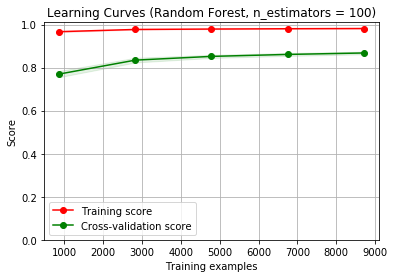

In [28]:
# 调用函数
title = "Learning Curves (Random Forest, n_estimators = 100)"
cv = cross_validation.ShuffleSplit(df_train_data.shape[0], n_iter=10,test_size=0.2, random_state=0)
estimator = RandomForestRegressor(n_estimators = 100)
plot_learning_curve(estimator, title, X, y, (0.0, 1.01), cv=cv, n_jobs=4)

plt.show()

从上面我们可以发现，训练集和测试集的评价指标相差过大，可能是由于模型发生了过拟合。

In [31]:
# 我们来对模型进行参数的调整，看是否可以缓解过拟合
print("随机森林回归/Random Forest(n_estimators=200, max_features=0.6, max_depth=15)")
for train, test in cv: 
    svc = RandomForestRegressor(n_estimators = 200, max_features=0.6, max_depth=15).fit(df_train_data[train], df_train_target[train])
    print("train score: {0:.3f}, test score: {1:.3f}\n".format(
        svc.score(df_train_data[train], df_train_target[train]), svc.score(df_train_data[test], df_train_target[test])))

随机森林回归/Random Forest(n_estimators=200, max_features=0.6, max_depth=15)
train score: 0.966, test score: 0.869

train score: 0.966, test score: 0.885

train score: 0.965, test score: 0.873

train score: 0.965, test score: 0.877

train score: 0.967, test score: 0.869

train score: 0.966, test score: 0.871

train score: 0.966, test score: 0.863

train score: 0.967, test score: 0.874

train score: 0.966, test score: 0.872

train score: 0.966, test score: 0.869



发现效果并不明显

我们把 “注册”和“未注册”的用户分开，然后进行预测。

In [33]:
df_train_registered = df_train_origin.drop(['datetime','casual','count'], axis=1)
df_train_casual = df_train_origin.drop(['datetime','count','registered'], axis=1)

In [34]:
df_train_casual.head()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,month,day,hour
0,1,0,0,1,9.84,14.395,81,0.0,3,1,5,0
1,1,0,0,1,9.02,13.635,80,0.0,8,1,5,1
2,1,0,0,1,9.02,13.635,80,0.0,5,1,5,2
3,1,0,0,1,9.84,14.395,75,0.0,3,1,5,3
4,1,0,0,1,9.84,14.395,75,0.0,0,1,5,4


In [35]:
df_train_registered.head()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,registered,month,day,hour
0,1,0,0,1,9.84,14.395,81,0.0,13,1,5,0
1,1,0,0,1,9.02,13.635,80,0.0,32,1,5,1
2,1,0,0,1,9.02,13.635,80,0.0,27,1,5,2
3,1,0,0,1,9.84,14.395,75,0.0,10,1,5,3
4,1,0,0,1,9.84,14.395,75,0.0,1,1,5,4


可以对其分别进行回归，然后在放在一起。

# 数据分析
添加到前面

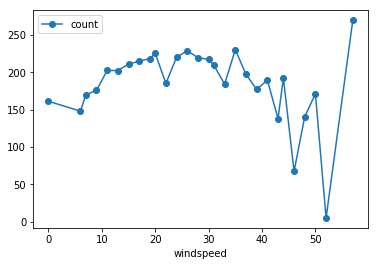

In [36]:
# 风速
df_train_origin.groupby('windspeed').mean().plot(y='count', marker='o')
plt.show()

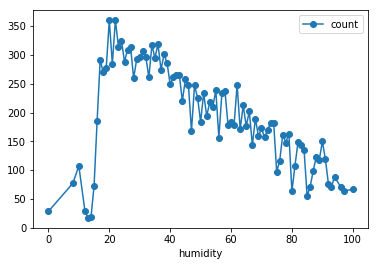

In [37]:
# 湿度
df_train_origin.groupby('humidity').mean().plot(y='count', marker='o')
plt.show()

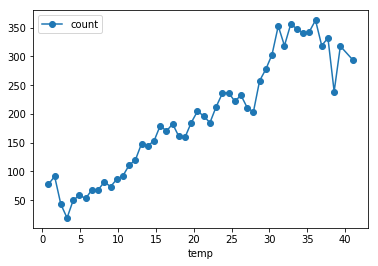

In [38]:
# 温度
df_train_origin.groupby('temp').mean().plot(y='count', marker='o')
plt.show()

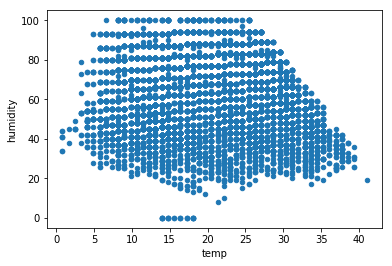

In [39]:
#温度湿度变化
df_train_origin.plot(x='temp', y='humidity', kind='scatter')
plt.show()

In [40]:
# 来看看相关度咯
corr = df_train_origin[['temp','weather','windspeed','day', 'month', 'hour','count']].corr()
corr

,temp,weather,windspeed,day,month,hour,count
temp,1.000000,-0.055035,-0.017852,-0.038466,0.257589,0.145430,0.394454
weather,-0.055035,1.000000,0.007261,-0.047692,0.012144,-0.022740,-0.128655
windspeed,-0.017852,0.007261,1.000000,-0.024804,-0.150192,0.146631,0.101369
day,-0.038466,-0.047692,-0.024804,1.000000,-0.002266,-0.002925,-0.002283
month,0.257589,0.012144,-0.150192,-0.002266,1.000000,-0.006818,0.166862
hour,0.145430,-0.022740,0.146631,-0.002925,-0.006818,1.000000,0.400601
count,0.394454,-0.128655,0.101369,-0.002283,0.166862,0.400601,1.000000


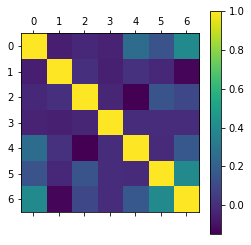

In [41]:
# 用颜色深浅来表示相关度
plt.figure()
plt.matshow(corr)
plt.colorbar()
plt.show()